# IMDB: MLM Insertion

In [ ]:
import json
import heapq
import os
import random
from typing import List

%pip install -U datasets
%pip install transformers
import torch
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader
from transformers import AutoModelForMaskedLM, AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments


plt.style.use('fivethirtyeight')

ROOT_DIR = "drive/My Drive/Colab Notebooks/nlp/results/twitter_mlm_insertion"
if not os.path.exists(ROOT_DIR):
    os.mkdir(ROOT_DIR)

Requirement already up-to-date: datasets in /usr/local/lib/python3.6/dist-packages (1.1.2)


## Defining augmentation function

In [ ]:
class MLMInsertionAugmenter:
    def __init__(self, model, tokenizer, p: float, min_mask: int = 1, topk: int = 5, uniform: bool = False, device=None):
        self.device = device or torch.device('cpu')
        self.model = model.eval().to(self.device)
        self.tokenizer = tokenizer
        self.vocab_words = list(tokenizer.get_vocab().keys())
        self.mask_token = tokenizer.mask_token
        self.mask_token_id = tokenizer.mask_token_id
        self.topk = topk
        self.min_mask = min_mask
        self.uniform = uniform
        self.p = p
        
    def __call__(self, text: str):
        if self.p == 0:
            return text
        words = np.array(text.split(), dtype='object')
        n_mask = max(self.min_mask, int(len(words) * self.p))
        masked_indices = np.sort(np.random.choice(len(words) + 1, size=n_mask))

        masked_words = np.insert(words, masked_indices, self.mask_token)
        masked_text = " ".join(masked_words)
        
        tokenizer_output = self.tokenizer([masked_text])
        input_ids = torch.tensor(tokenizer_output['input_ids']).to(self.device)
        attention_mask = torch.tensor(tokenizer_output['attention_mask']).to(self.device)
        with torch.no_grad():
            output = self.model(input_ids)
            predicted_logits = output.logits[input_ids == self.mask_token_id]
            predicted_probas = predicted_logits.softmax(1)
            
        predicted_words = [self.sample_word(probas).strip() for probas in predicted_probas]
        
        new_words = np.insert(words, masked_indices, predicted_words)
        new_text = " ".join(new_words)
        return new_text
    
    
    def sample_word(self, predicted_probas):
        if hasattr(predicted_probas, 'tolist'):
            predicted_probas = predicted_probas.tolist()
        most_probable = heapq.nlargest(self.topk, zip(self.vocab_words, predicted_probas), key=lambda t: t[1])
        words, probas = zip(*most_probable)
        word = random.choice(words) if self.uniform else random.choices(words, weights=probas)[0]
        return self.tokenizer.convert_tokens_to_string(word).strip()

In [ ]:
class DatasetWithAugmentation(torch.utils.data.Dataset):
    def __init__(self, dataset, augmenter, augmentation_prob: float = 0.9):
        self.dataset = dataset
        self.augmenter = augmenter
        self.augmentation_prob = augmentation_prob

    def __getitem__(self, i):
        try:
            item = self.dataset[i]
            if random.random() < self.augmentation_prob:
                item['text'] = self.augmenter(item['text'])
            return item
        except:
            print(item)
            raise Exception(f"Something went wrong when augmenting item number {i}")

    def __len__(self):
        return len(self.dataset)


def get_datasets(dataset_name, augmenter, train_size, val_size=5_000, test_size=None, augmentation_prob=0.5, random_seed: int = 42):
    """Returns a tuple of train, validation and test datasets of sizes determined by arguments."""
    dataset = load_dataset(dataset_name, split="train")
    # We want test and validation data to be the same for every experiment
    test_split = dataset.train_test_split(test_size=test_size, seed=random_seed)
    test_dataset = test_split["test"]
    train_val_split = test_split["train"].train_test_split(test_size=val_size, seed=random_seed)
    # Validation and test sets
    train_dataset = train_val_split["train"].train_test_split(train_size=train_size, seed=random_seed)["train"]
    train_dataset = DatasetWithAugmentation(train_dataset, augmenter, augmentation_prob=augmentation_prob)
    val_dataset = train_val_split["test"]
    return train_dataset, val_dataset, test_dataset


class DataCollator:
    def __init__(self, tokenizer, label_colname='label'):
        self.tokenizer = tokenizer
        self.label_colname = label_colname
        
    def __call__(self, examples: List[dict]):
        labels = [0 if example['sentiment'] == 0 else 1 for example in examples]
        texts = [example['text'] for example in examples]
        tokenizer_output = self.tokenizer(texts, truncation=True, padding=True)
        return {
            'labels': torch.tensor(labels), 
            'input_ids': torch.tensor(tokenizer_output['input_ids']), 
            'attention_mask': torch.tensor(tokenizer_output['attention_mask'])
            }


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
AUGMENTATION_PROB = 0.7

tokenizer = AutoTokenizer.from_pretrained('roberta-base', use_fast=False)  # we cannot use Fast tokenizer for MLMInsertionAugmenter
data_collator = DataCollator(tokenizer, 'sentiment')

device = torch.device('cuda')
mlm_model = AutoModelForMaskedLM.from_pretrained('roberta-base', return_dict=True).eval()

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
augmenter = MLMInsertionAugmenter(mlm_model, tokenizer, 0.2, min_mask=1, topk=10, uniform=False, device=torch.device('cuda'))

In [ ]:
augmenter('I love you ')

'I love you .'

In [ ]:
train_size = 100

FRACTIONS = [0.0, 0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6]
accuracies = list()

for fraction in FRACTIONS:

    model = AutoModelForSequenceClassification.from_pretrained('roberta-base', return_dict=True)
    augmenter = MLMInsertionAugmenter(mlm_model, tokenizer, fraction, min_mask=1, topk=10, uniform=False, device=device)

    train_dataset, val_dataset, test_dataset = get_datasets("sentiment140", augmenter, train_size, val_size=1_000, test_size=20_000, augmentation_prob=AUGMENTATION_PROB)
    print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")
    print(f"Augmentation fraction: {fraction}")
    print(train_dataset[0])
    print(val_dataset[0])
    print(test_dataset[0])
    output_dir = os.path.join(ROOT_DIR, f"train_size_{train_size}_p_{fraction}")

    num_train_epochs = 9

    # https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments
    training_args = TrainingArguments(
        learning_rate=3e-5,
        weight_decay=0.01,
        output_dir=output_dir,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        gradient_accumulation_steps=2,
        warmup_steps=0,  # don't have any intuition for the right value here
        logging_dir=output_dir,
        logging_steps=5,
        load_best_model_at_end=False,
        evaluation_strategy='epoch',
        remove_unused_columns=False,
        no_cuda=False,
        metric_for_best_model="eval_accuracy"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=data_collator,
        compute_metrics=compute_metrics
        
    )

    trainer.train()

    test_result = trainer.evaluate(test_dataset)

    print(test_result)
    accuracies.append(test_result['eval_accuracy'])


    with open(os.path.join(output_dir, 'test_result.json'), 'w') as f:
        json.dump(test_result, f, indent=4)

    print()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 1000, Test size: 20000
Augmentation fraction: 0.0
{'date': 'Mon May 04 06:28:55 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 4, 'text': "2nd result of the day: found my timeout book of bars whiiich means i've now recovered everything I thought i'd lost. Small victories = ", 'user': 'Bandrew'}
{'date': 'Wed Jun 24 23:21:53 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 0, 'text': "yea!!!! I think I have someone to watch the dogs while we're away. just have to kennel for 2 days instead of 11. no one wanted Zhu ", 'user': 'lindentreephoto'}
{'date': 'Sun Jun 07 07:43:33 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 0, 'text': 'why am i awake so early?  damn projects. super nervous for the science one. mines gunna be so lame i dont wanna fail ', 'user': '_stacey_rae'}


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.688572,0.691712,0.506000,0.671979,0.506000,1.000000
1,0.762655,0.690137,0.507000,0.672425,0.506507,1.000000
2,0.738753,0.684074,0.515000,0.674715,0.510660,0.994071
3,0.716569,0.658528,0.569000,0.690151,0.542373,0.948617
4,0.505957,0.600710,0.683000,0.717720,0.653160,0.796443
5,0.450586,0.561520,0.707000,0.703741,0.720497,0.687747
6,0.300618,0.593582,0.721000,0.749776,0.686371,0.826087
7,0.224942,0.555019,0.739000,0.741328,0.743539,0.739130
8,0.171442,0.554884,0.748000,0.750495,0.751984,0.749012


{'eval_loss': 0.5538463592529297, 'eval_accuracy': 0.7421, 'eval_f1': 0.7435616983195785, 'eval_precision': 0.7390058306156735, 'eval_recall': 0.7481740870435217, 'epoch': 8.923076923076923, 'total_flos': 26391296009760}



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 1000, Test size: 20000
Augmentation fraction: 0.01
{'date': 'Mon May 04 06:28:55 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 4, 'text': "2nd result of the day: found back my timeout book of bars whiiich means i've now recovered everything I thought i'd lost. Small victories =", 'user': 'Bandrew'}
{'date': 'Wed Jun 24 23:21:53 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 0, 'text': "yea!!!! I think I have someone to watch the dogs while we're away. just have to kennel for 2 days instead of 11. no one wanted Zhu ", 'user': 'lindentreephoto'}
{'date': 'Sun Jun 07 07:43:33 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 0, 'text': 'why am i awake so early?  damn projects. super nervous for the science one. mines gunna be so lame i dont wanna fail ', 'user': '_stacey_rae'}


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.694149,0.692773,0.506000,0.671979,0.506000,1.000000
1,0.754219,0.687935,0.510000,0.673768,0.508032,1.000000
2,0.752238,0.678012,0.609000,0.702209,0.571252,0.911067
3,0.737892,0.619520,0.687000,0.709917,0.668412,0.756917
4,0.457940,0.567644,0.703000,0.723721,0.683656,0.768775
5,0.430317,0.552540,0.718000,0.727273,0.712121,0.743083
6,0.289989,0.561525,0.730000,0.737864,0.725191,0.750988
7,0.224440,0.572502,0.736000,0.739130,0.739130,0.739130
8,0.173368,0.581270,0.738000,0.748077,0.728464,0.768775


{'eval_loss': 0.5680694580078125, 'eval_accuracy': 0.7471, 'eval_f1': 0.7543467702768335, 'eval_precision': 0.7329872581406324, 'eval_recall': 0.7769884942471236, 'epoch': 8.923076923076923, 'total_flos': 26196846424560}



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 1000, Test size: 20000
Augmentation fraction: 0.1
{'date': 'Mon May 04 06:28:55 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 4, 'text': "2nd result of the day: found my timeout book of bars whiiich that means i've now recovered everything I thought i'd lost. Small victories = )", 'user': 'Bandrew'}
{'date': 'Wed Jun 24 23:21:53 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 0, 'text': "yea!!!! I think I have someone to watch the dogs while we're away. just have to kennel for 2 days instead of 11. no one wanted Zhu ", 'user': 'lindentreephoto'}
{'date': 'Sun Jun 07 07:43:33 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 0, 'text': 'why am i awake so early?  damn projects. super nervous for the science one. mines gunna be so lame i dont wanna fail ', 'user': '_stacey_rae'}


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.709179,0.691316,0.506000,0.671979,0.506000,1.000000
1,0.768439,0.687730,0.516000,0.675603,0.511156,0.996047
2,0.762632,0.679208,0.586000,0.696925,0.553488,0.940711
3,0.740407,0.644995,0.678000,0.614833,0.778788,0.507905
4,0.557707,0.587050,0.690000,0.713494,0.670139,0.762846
5,0.489175,0.547248,0.718000,0.729885,0.708178,0.752964
6,0.303142,0.543860,0.729000,0.740173,0.718808,0.762846
7,0.245081,0.557314,0.741000,0.752627,0.728281,0.778656
8,0.171062,0.562349,0.746000,0.754826,0.737736,0.772727


{'eval_loss': 0.5483174920082092, 'eval_accuracy': 0.7557, 'eval_f1': 0.763550135501355, 'eval_precision': 0.739431999250164, 'eval_recall': 0.7892946473236618, 'epoch': 8.923076923076923, 'total_flos': 26618652447840}



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 1000, Test size: 20000
Augmentation fraction: 0.15
{'date': 'Mon May 04 06:28:55 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 4, 'text': "2nd positive result of the day: found my timeout book of bars whiiich means i've just now recovered everything I really thought i'd lost. Small victories =", 'user': 'Bandrew'}
{'date': 'Wed Jun 24 23:21:53 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 0, 'text': "yea!!!! I think I have someone to watch the dogs while we're away. just have to kennel for 2 days instead of 11. no one wanted Zhu ", 'user': 'lindentreephoto'}
{'date': 'Sun Jun 07 07:43:33 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 0, 'text': 'why am i awake so early?  damn projects. super nervous for the science one. mines gunna be so lame i dont wanna fail ', 'user': '_stacey_rae'}


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.691943,0.694359,0.506000,0.671979,0.506000,1.000000
1,0.761340,0.691869,0.506000,0.671979,0.506000,1.000000
2,0.758989,0.687686,0.508000,0.672872,0.507014,1.000000
3,0.738916,0.669779,0.664000,0.654321,0.682403,0.628458
4,0.618284,0.616685,0.692000,0.701550,0.688213,0.715415
5,0.576496,0.560397,0.719000,0.720398,0.725451,0.715415
6,0.421740,0.548072,0.727000,0.747922,0.701906,0.800395
7,0.350708,0.533772,0.740000,0.747573,0.734733,0.760870
8,0.286944,0.533870,0.752000,0.761538,0.741573,0.782609


{'eval_loss': 0.518985390663147, 'eval_accuracy': 0.75265, 'eval_f1': 0.7591176900228854, 'eval_precision': 0.7394232593435781, 'eval_recall': 0.7798899449724862, 'epoch': 8.923076923076923, 'total_flos': 27061399195680}



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 1000, Test size: 20000
Augmentation fraction: 0.2
{'date': 'Mon May 04 06:28:55 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 4, 'text': "2nd major result of saving the day: found my timeout book instead of bars whiiich means i've now recovered everything I thought i'd lost. - Small victories =", 'user': 'Bandrew'}
{'date': 'Wed Jun 24 23:21:53 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 0, 'text': "yea!!!! I think I have someone to watch the dogs while we're away. just have to kennel for 2 days instead of 11. no one wanted Zhu ", 'user': 'lindentreephoto'}
{'date': 'Sun Jun 07 07:43:33 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 0, 'text': 'why am i awake so early?  damn projects. super nervous for the science one. mines gunna be so lame i dont wanna fail ', 'user': '_stacey_rae'}


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.700842,0.692921,0.506000,0.671979,0.506000,1.000000
1,0.761220,0.692347,0.506000,0.671979,0.506000,1.000000
2,0.750940,0.686710,0.508000,0.672872,0.507014,1.000000
3,0.737152,0.661624,0.656000,0.663405,0.656977,0.669960
4,0.571026,0.626051,0.670000,0.706406,0.642395,0.784585
5,0.584306,0.608373,0.683000,0.647386,0.740458,0.575099
6,0.475239,0.601359,0.690000,0.712430,0.671329,0.758893
7,0.413077,0.592718,0.692000,0.696252,0.694882,0.697628
8,0.355839,0.591746,0.694000,0.697628,0.697628,0.697628


{'eval_loss': 0.5830125212669373, 'eval_accuracy': 0.7131, 'eval_f1': 0.714470541401274, 'eval_precision': 0.7107217107217108, 'eval_recall': 0.7182591295647824, 'epoch': 8.923076923076923, 'total_flos': 27560985053040}



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 1000, Test size: 20000
Augmentation fraction: 0.25
{'date': 'Mon May 04 06:28:55 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 4, 'text': "2nd result of the the day: found my timeout little book of bars whiiich means that i've just now recovered everything I thought i'd lost. Small victories . = D", 'user': 'Bandrew'}
{'date': 'Wed Jun 24 23:21:53 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 0, 'text': "yea!!!! I think I have someone to watch the dogs while we're away. just have to kennel for 2 days instead of 11. no one wanted Zhu ", 'user': 'lindentreephoto'}
{'date': 'Sun Jun 07 07:43:33 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 0, 'text': 'why am i awake so early?  damn projects. super nervous for the science one. mines gunna be so lame i dont wanna fail ', 'user': '_stacey_rae'}


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.701543,0.697547,0.506000,0.671979,0.506000,1.000000
1,0.765588,0.694566,0.506000,0.671979,0.506000,1.000000
2,0.747124,0.683099,0.506000,0.671979,0.506000,1.000000
3,0.719148,0.625574,0.666000,0.705467,0.636943,0.790514
4,0.461905,0.588709,0.680000,0.718310,0.647619,0.806324
5,0.381504,0.570167,0.714000,0.725000,0.705993,0.745059
6,0.249905,0.658697,0.710000,0.746946,0.668750,0.845850
7,0.217424,0.609848,0.719000,0.731100,0.708720,0.754941
8,0.172892,0.614806,0.736000,0.748571,0.722426,0.776680


{'eval_loss': 0.6251196265220642, 'eval_accuracy': 0.7348, 'eval_f1': 0.7466080642079114, 'eval_precision': 0.7144555179665356, 'eval_recall': 0.7817908954477238, 'epoch': 8.923076923076923, 'total_flos': 28243054367280}



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 1000, Test size: 20000
Augmentation fraction: 0.3
{'date': 'Mon May 04 06:28:55 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 4, 'text': "2nd result of the day: found my timeout book full of bars , whiiich means that i've now recovered everything that I 'd thought that i'd completely lost. Small victories =", 'user': 'Bandrew'}
{'date': 'Wed Jun 24 23:21:53 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 0, 'text': "yea!!!! I think I have someone to watch the dogs while we're away. just have to kennel for 2 days instead of 11. no one wanted Zhu ", 'user': 'lindentreephoto'}
{'date': 'Sun Jun 07 07:43:33 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 0, 'text': 'why am i awake so early?  damn projects. super nervous for the science one. mines gunna be so lame i dont wanna fail ', 'user': '_stacey_rae'}


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.697012,0.696674,0.506000,0.671979,0.506000,1.000000
1,0.767754,0.696263,0.506000,0.671979,0.506000,1.000000
2,0.766550,0.690993,0.506000,0.671979,0.506000,1.000000
3,0.740667,0.678466,0.543000,0.680196,0.526544,0.960474
4,0.642934,0.657928,0.620000,0.703125,0.581395,0.889328
5,0.652968,0.612650,0.688000,0.717902,0.661667,0.784585
6,0.517936,0.587015,0.684000,0.714286,0.658333,0.780632
7,0.423005,0.569153,0.697000,0.714420,0.682883,0.749012
8,0.376355,0.568730,0.702000,0.717803,0.689091,0.749012


{'eval_loss': 0.5746767520904541, 'eval_accuracy': 0.71735, 'eval_f1': 0.7331602548973329, 'eval_precision': 0.6940125111706881, 'eval_recall': 0.7769884942471236, 'epoch': 8.923076923076923, 'total_flos': 28832386187040}



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 1000, Test size: 20000
Augmentation fraction: 0.4
{'date': 'Mon May 04 06:28:55 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 4, 'text': "2nd result find of the day: found my second timeout book of bars yesterday , whiiich means i've now sort % recovered from everything I thought that i'd lost. Small er victories =", 'user': 'Bandrew'}
{'date': 'Wed Jun 24 23:21:53 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 0, 'text': "yea!!!! I think I have someone to watch the dogs while we're away. just have to kennel for 2 days instead of 11. no one wanted Zhu ", 'user': 'lindentreephoto'}
{'date': 'Sun Jun 07 07:43:33 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 0, 'text': 'why am i awake so early?  damn projects. super nervous for the science one. mines gunna be so lame i dont wanna fail ', 'user': '_stacey_rae'}


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.701469,0.691924,0.524000,0.677069,0.515496,0.986166
1,0.753766,0.688741,0.590000,0.678683,0.562338,0.855731
2,0.769194,0.686191,0.576000,0.693642,0.546697,0.948617
3,0.764473,0.682085,0.602000,0.690031,0.569409,0.875494
4,0.650256,0.675341,0.609000,0.705350,0.570037,0.924901
5,0.715660,0.658746,0.679000,0.703601,0.660312,0.752964
6,0.687245,0.637343,0.704000,0.692946,0.729258,0.660079
7,0.622557,0.616876,0.712000,0.698745,0.742222,0.660079
8,0.620369,0.606795,0.721000,0.710881,0.747277,0.677866


{'eval_loss': 0.6045017242431641, 'eval_accuracy': 0.7195, 'eval_f1': 0.6996144784750482, 'eval_precision': 0.752563068770879, 'eval_recall': 0.6536268134067034, 'epoch': 8.923076923076923, 'total_flos': 30169601026800}



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 1000, Test size: 20000
Augmentation fraction: 0.5
{'date': 'Mon May 04 06:28:55 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 4, 'text': "My My 2nd greatest result as of course the day: found my first timeout in the book of bars , whiiich means i've now recovered from everything I thought i'd already lost. Small victories : =", 'user': 'Bandrew'}
{'date': 'Wed Jun 24 23:21:53 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 0, 'text': "yea!!!! I think I have someone to watch the dogs while we're away. just have to kennel for 2 days instead of 11. no one wanted Zhu ", 'user': 'lindentreephoto'}
{'date': 'Sun Jun 07 07:43:33 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 0, 'text': 'why am i awake so early?  damn projects. super nervous for the science one. mines gunna be so lame i dont wanna fail ', 'user': '_stacey_rae'}


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.706284,0.692577,0.506000,0.671979,0.506000,1.000000
1,0.765905,0.691216,0.506000,0.671979,0.506000,1.000000
2,0.747553,0.687599,0.507000,0.672425,0.506507,1.000000
3,0.746544,0.678131,0.647000,0.685663,0.623987,0.760870
4,0.646966,0.661281,0.688000,0.683570,0.702083,0.666008
5,0.662088,0.628105,0.714000,0.694444,0.755814,0.642292
6,0.622605,0.616457,0.670000,0.721754,0.629412,0.845850
7,0.563271,0.583208,0.703000,0.717949,0.691042,0.747036
8,0.524231,0.573849,0.718000,0.720792,0.722222,0.719368


{'eval_loss': 0.5703228712081909, 'eval_accuracy': 0.7193, 'eval_f1': 0.7230936174410575, 'eval_precision': 0.7131043875863411, 'eval_recall': 0.7333666833416709, 'epoch': 8.923076923076923, 'total_flos': 31602544893120}



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 1000, Test size: 20000
Augmentation fraction: 0.6
{'date': 'Mon May 04 06:28:55 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 4, 'text': "2nd result of the day: found my timeout book of bars whiiich means i've now recovered everything I thought i'd lost. Small victories = ", 'user': 'Bandrew'}
{'date': 'Wed Jun 24 23:21:53 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 0, 'text': "yea!!!! I think I have someone to watch the dogs while we're away. just have to kennel for 2 days instead of 11. no one wanted Zhu ", 'user': 'lindentreephoto'}
{'date': 'Sun Jun 07 07:43:33 PDT 2009', 'query': 'NO_QUERY', 'sentiment': 0, 'text': 'why am i awake so early?  damn projects. super nervous for the science one. mines gunna be so lame i dont wanna fail ', 'user': '_stacey_rae'}


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.699085,0.697672,0.506000,0.671979,0.506000,1.000000
1,0.772871,0.693380,0.506000,0.671979,0.506000,1.000000
2,0.793959,0.689596,0.507000,0.672425,0.506507,1.000000
3,0.738652,0.685885,0.539000,0.682725,0.523759,0.980237
4,0.666360,0.678137,0.573000,0.692141,0.544835,0.948617
5,0.710661,0.659776,0.658000,0.704663,0.625767,0.806324
6,0.666724,0.637116,0.655000,0.716049,0.613540,0.859684
7,0.612968,0.611571,0.664000,0.716216,0.625369,0.837945
8,0.573511,0.597496,0.681000,0.720421,0.647244,0.812253


{'eval_loss': 0.5979194045066833, 'eval_accuracy': 0.69195, 'eval_f1': 0.7294840834248079, 'eval_precision': 0.65, 'eval_recall': 0.8311155577788895, 'epoch': 8.923076923076923, 'total_flos': 32841039174240}



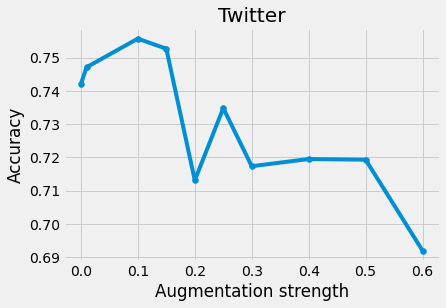

In [ ]:
plt.plot(FRACTIONS, accuracies)
plt.scatter(FRACTIONS, accuracies)
plt.title('Twitter')
plt.xlabel('Augmentation strength')
plt.ylabel('Accuracy')
plt.savefig(os.path.join(ROOT_DIR, 'twitter_1000_mlm_insertion_strength.eps'), format='eps', bbox_inches='tight')